In [93]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2 as cv

from skimage.feature import hog 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import os
import shutil as sh

sns.set_theme(style="darkgrid")

## Modèle 1 : binaire entre chaque dessin

### Préparation du jeux de données

In [79]:
def create_dataset1(source_dir, dest_dir) :
    myfolder = os.listdir(source_dir)
    for folder in myfolder : 
        path2 = os.path.join(source_dir,folder)
        classes = os.listdir(path2)
        for classe in classes : 
            path3 = os.path.join(path2,classe)
            myimages = os.listdir(path3)
            myclass = source_dir+"_"+classe
            for image in myimages : 
                all_path = os.path.join(path3,image)
                path_dest1 = os.path.join(dest_dir,folder)
                path_dest_final = os.path.join(path_dest1,myclass)
                if not os.path.isdir(path_dest_final) : 
                    os.makedirs(path_dest_final) # si il n'existe pas il le crée
                sh.copy(all_path, path_dest_final)

In [98]:
spiral_path = "spiral"
wave_path = "wave"
dest_path_spiral = "Dataset_bin_spiral"
dest_path_wave = "Dataset_bin_wave"
create_dataset1(spiral_path,dest_path_spiral)
create_dataset1(wave_path,dest_path_wave)

### Chargement et binarisation des images

In [119]:
def loadimages(source_dir) :
    myimages = list()
    mylabels = list()
    myclasses = os.listdir(source_dir)
    for classe in myclasses :
        mypath = os.path.join(source_dir,classe)
        mesimages = os.listdir(mypath)
        images_path = [os.path.join(mypath,x) for x in mesimages]
        for path in images_path :
            test_image = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)
            histo_test = cv.calcHist([test_image], channels=[0], mask=None,histSize=[256], ranges=[0, 256])
            hist_argmax = histo_test.argmax()
            test_image2 = test_image.copy()
            test_image_filtre1 = test_image2>hist_argmax-30
            test_image_filtre2 = test_image2<=hist_argmax-30
            test_image[~test_image_filtre1] = 0
            test_image[~test_image_filtre2] = 255
            test_image = cv.resize(test_image,(227,512))
            myimages.append(test_image)
            mylabels.append(classe)
    return myimages, mylabels

## 1) Wave

In [120]:
train_path = "./Dataset_bin_wave/training/"
test_path = "./Dataset_bin_wave/testing/"
train_images, train_labels = loadimages(train_path)
test_images, test_labels = loadimages(test_path)

### HoG

In [146]:
def hog_list (listimage) :
    fv = []
    hog_image = []
    for i in range(len(listimage)) :
        a, b = hog(listimage[i], orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
        fv.append(a)
        hog_image.append(b)
    return pd.DataFrame(fv),hog_image

In [147]:
features_train, hog_images_train = hog_list(train_images)
features_test, hog_images_test = hog_list(test_images)

### Classifieur

#### 1) KNN

In [148]:
parameters = {'n_neighbors':np.arange(1,20,1), 'p' : np.arange(1,3,1)}
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(features_train,train_labels)
knn=KNeighborsClassifier(**clf.best_params_)
knn.fit(features_train,train_labels)

KNeighborsClassifier()

In [149]:
clf.best_params_

{'n_neighbors': 5, 'p': 2}

Evaluation du modèle

In [150]:
yknn=knn.predict(features_test)
print("Accuracy : ",metrics.accuracy_score(test_labels, yknn))
print("F1-score : ", metrics.f1_score(test_labels, yknn, average='macro'))
print(metrics.classification_report(test_labels, yknn))

Accuracy :  0.7
F1-score :  0.6969696969696968
                precision    recall  f1-score   support

  wave_healthy       0.67      0.80      0.73        15
wave_parkinson       0.75      0.60      0.67        15

      accuracy                           0.70        30
     macro avg       0.71      0.70      0.70        30
  weighted avg       0.71      0.70      0.70        30



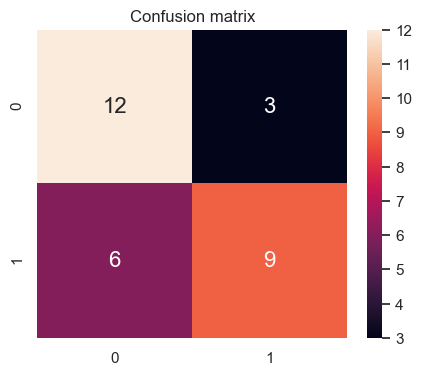

In [151]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(5,4))
sns.heatmap(metrics.confusion_matrix(test_labels, yknn), annot=True, annot_kws={"size": 16})
plt.title('Confusion matrix')
plt.show()